In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
import numpy as np
import os
from tqdm.notebook import tqdm


from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights, deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# Segmentation

In this part we explore segmentation using neural networks. Before neural networks, automated segmentation was performed using a multitude of techniques such as graph cuts, superpixel based segmentation, .... The advantage of Neural Networks is that the feature extraction is incorporated in the model, making the learning 'end-to-end'. This feature extraction part can therefore also be optimized for learning the segmentation. In this work we provide 2 models: the Fully Convolutional Network (FCN) model and a Unet. 

## The data




In [ ]:
def plot_examples(images, masks, num_examples=4):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 10))
    for i in range(num_examples):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].cpu().numpy()
        
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=mask.max())
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()
batch_images, batch_masks = next(iter(train_loader))

# Plot a few example images
plot_examples(batch_images, batch_masks)

## Dataloader

We provide the code for a custom dataloader, which loads the data from the provided folder, but first normalizes them by the mean pixel value $\mu$ and standard deviation $\sigma$, where $z = \frac{x - \mu}{\sigma}$. This is important in many machine learning applications, to make the data comparible to eachother and ... . The loader outputs a tuple of the image and the mask, in a batch. 

In [ ]:

def calculate_mean_std(dataset):
    # Initialize lists to store channel-wise means and standard deviations
    mean_list = []
    std_list = []

    # Iterate over the dataset to compute mean and standard deviation
    for sample in dataset:
        image = sample[0]  # Assuming the image is the first element of the sample
        # Compute mean and standard deviation along height, width, and channel dimensions
        mean = torch.mean(image, dim=(1, 2))
        std = torch.std(image, dim=(1, 2))
        mean_list.append(mean)
        std_list.append(std)

    mean_tensor = torch.stack(mean_list)
    std_tensor = torch.stack(std_list)

    dataset_mean = torch.mean(mean_tensor, dim=0)
    dataset_std = torch.mean(std_tensor, dim=0)

    return dataset_mean, dataset_std

train_mean, train_std = calculate_mean_std(full_dataset)

In [2]:

class CustomDataset(Dataset):
    def __init__(self, data_folder, img_size, image_files, transform=None):
        self.data_folder = data_folder
        self.img_size = img_size
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_folder, 'img', self.image_files[idx])
        image = np.load(img_path, allow_pickle=True)

        # Load mask
        mask_path = os.path.join(self.data_folder, 'seg', self.image_files[idx])
        mask = np.load(mask_path, allow_pickle=True)

        # Resize image and mask
        image = resize(image, self.img_size, anti_aliasing=True)
        mask = resize(mask, self.img_size, anti_aliasing=False, order=0)

        # Convert image and mask to PyTorch tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()
        
        
        if self.transform:
            image = self.transform(image)

        return (image, mask)


normalize = transforms.Normalize(mean=[0.4552, 0.4438, 0.4090], std=[0.2319, 0.2270, 0.2325])



transform = transforms.Compose([ 
    normalize  
])




train_folder = "/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/train/"
img_size = (256, 256)

image_files = sorted(file for file in os.listdir(os.path.join(train_folder, 'img')) if not file.startswith('.'))


train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_folder, img_size, train_files, transform)
val_dataset = CustomDataset(train_folder, img_size, val_files)

full_dataset = CustomDataset(train_folder, img_size, image_files)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Test loader

In [3]:
import re
img_size = (256,256)
class TestDataset(Dataset):
    def __init__(self, data_folder, img_size, image_files, transform=None):
        self.data_folder = data_folder
        self.img_size = img_size
        self.image_files = sorted(image_files, key=lambda x: int(re.findall(r'\d+', x)[0])) 
        self.transform = transform
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_folder, 'img', self.image_files[idx])
        image = np.load(img_path)

        # Resize image
        image = resize(image, self.img_size, anti_aliasing=True)

        # Convert image to PyTorch tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float()

        
        if self.transform:
            image = self.transform(image)

        return image


normalize = transforms.Normalize(mean=[0.4552, 0.4438, 0.4090], std=[0.2319, 0.2270, 0.2325])



transform = transforms.Compose([ 
    normalize  
])

test_folder = "/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/"

# List all image files in the test folder
test_image_files = sorted(file for file in os.listdir(os.path.join(test_folder, 'img')) if not file.startswith('.'))

# Create TestDataset instance for the test set
test_dataset = TestDataset(test_folder, img_size, test_image_files, transform= False)

batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Training

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

# Model evaluation

In [8]:

num_classes =21
model = deeplabv3_resnet50(num_classes=num_classes)
model = model.to('cpu')
weights = torch.load('/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/models/deeplabv3_epoch_8.pth', map_location=torch.device('cpu'))
model.load_state_dict(weights)


<All keys matched successfully>

In [6]:
def make_predictions(model, test_loader):
    device = next(model.parameters()).device  # Get the device of the model's parameters
    model.eval()  # Set model to evaluation mode
    predictions = []
    i=0
    with torch.no_grad():
        for images_batch in test_loader:
            images_batch = images_batch.to(device)  # Move input data to the same device as the model
            outputs = model(images_batch)['out']
            predictions.append(outputs)
            i+=1
            print(i)
    return torch.cat(predictions)

In [7]:
test_predictions = make_predictions(model, test_loader)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


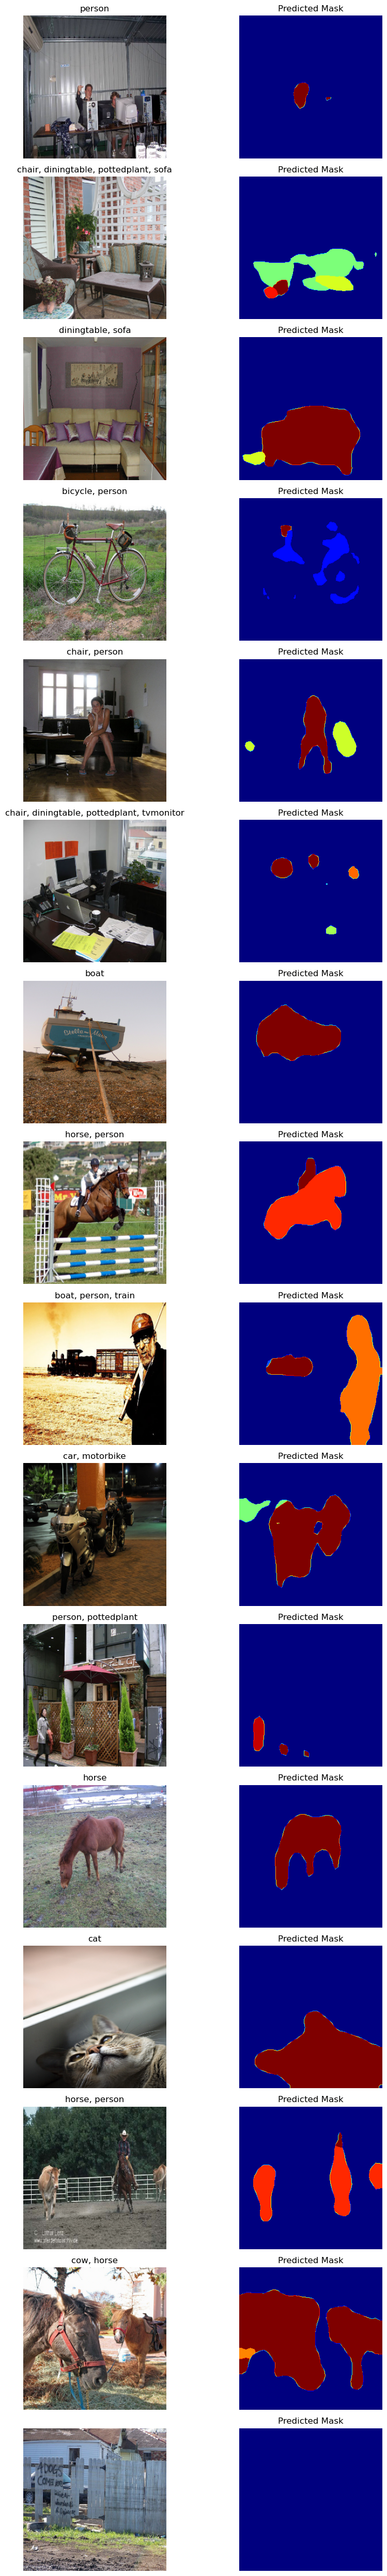

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

class_names = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", 
               "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", 
               "sheep", "sofa", "train", "tvmonitor"]

def plot_test_predictions(test_dataset, test_predictions, num_examples=16):
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=False)
    images_batch = next(iter(test_loader))
    fig, axes = plt.subplots(num_examples, 2, figsize=(10,50))
    for i in range(num_examples):
        image = images_batch[i].permute(1, 2, 0).cpu().numpy()
        prediction = test_predictions[i].argmax(dim=0).cpu().numpy()  # Convert logits to class predictions
        
        unique_classes = np.unique(prediction)[1:]
        #print(unique_classes)
        class_labels = [class_names[c] for c in unique_classes]
        title = ', '.join(class_labels)
        
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'{title}')

        axes[i, 1].imshow(prediction, cmap='jet', vmin=0, vmax=prediction.max())
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Plot some example predictions
plot_test_predictions(test_dataset, test_predictions)


# Compute IoU

In [26]:
def compute_iou(outputs, masks):
    # Convert outputs to binary predictions
    predictions = torch.argmax(outputs, dim=1)
    
    # Compute intersection and union
    intersection = torch.sum(predictions & masks)
    union = torch.sum(predictions | masks)
    
    # Avoid division by zero
    iou = torch.true_divide(intersection, union + 1e-8)
    
    return iou

In [24]:
next(iter(val_loader))[1].shape

torch.Size([8, 256, 256])

In [27]:
def compute_mean_dice(model, val_loader):
    device = next(model.parameters()).device
    
    model.eval()  # Set model to evaluation mode
    
    dice_scores = []
    i = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Predict masks
            outputs = model(images)['out']
            
            # Compute Dice coefficient
            dice_score = compute_iou(outputs, masks)
            
            dice_scores.append(dice_score)
            i+=1
            print(f"{i}/{len(val_loader)}: Dice coefficient: {dice_score:.4f}")
    
    mean_dice = np.mean(dice_scores)
    
    return mean_dice

# Calculate mean Dice coefficient over the entire validation loader
mean_dice = compute_mean_dice(model, val_loader)
print("Mean Dice coefficient:", mean_dice)

1/19: Dice coefficient: 0.6706
2/19: Dice coefficient: 0.6457
3/19: Dice coefficient: 0.4146
4/19: Dice coefficient: 0.5634
5/19: Dice coefficient: 0.5994
6/19: Dice coefficient: 0.5834
7/19: Dice coefficient: 0.7956
8/19: Dice coefficient: 0.6736
9/19: Dice coefficient: 0.7018
10/19: Dice coefficient: 0.7540
11/19: Dice coefficient: 0.7050
12/19: Dice coefficient: 0.7696
13/19: Dice coefficient: 0.7637
14/19: Dice coefficient: 0.6947
15/19: Dice coefficient: 0.6900
16/19: Dice coefficient: 0.4921
17/19: Dice coefficient: 0.4855
18/19: Dice coefficient: 0.5978
19/19: Dice coefficient: 0.4393
Mean Dice coefficient: 0.63366735


# Submission

In [28]:
test_df = pd.read_csv('/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/Users/thibaultheintz/Documents/GitHub/Computer_Vision_Group_Assignment_2/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))


The test set contains 750 examples.


In [32]:
test_predictions[0].shape

torch.Size([21, 256, 256])

In [33]:
# populating the dataframe for submission


import pandas as pd

model.eval()

for idx, row in tqdm(test_df.iterrows(), total = len(test_dataset)):
    segmentation_mask = test_predictions[idx].argmax(dim=0).cpu().numpy()
    
    # Resize the segmentation mask to match the original image size
    resized_segmentation_mask = resize(segmentation_mask, row['seg'].shape, anti_aliasing=False, order=0)
    
    # Update the seg column in the test dataframe with the resized segmentation mask
    test_df.at[idx, 'seg'] = resized_segmentation_mask

  0%|          | 0/750 [00:00<?, ?it/s]

In [41]:
np.unique(test_df.iloc(0)[26]['seg']) # check if the seg column has been updated and has unique values

array([ 0,  7, 14])

In [ ]:
test_df.to_csv("test_df.csv")

In [42]:
test_df.to_pickle("test_df.pkl")